# Обработка новостей первой недели

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sklearn.cluster as sc
import gensim
import random
import pandas as pd
import numpy as np
import time
import datetime
from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

md = '/content/drive/My Drive/Colab Notebooks/Diplom/'

In [3]:
months = {
    'января':'01',
    'февраля':'02',
    'марта':'03',
    'апреля':'04',
    'мая':'05',
    'июня':'06',
    'июля':'07',
    'августа':'08',
    'сентября':'09',
    'октября':'10',
    'ноября':'11',
    'декабря':'12'
}

In [4]:
def show_elbow_plot(model,vocab_m):
  scores = []
  for n_cl in tqdm(range(1,10)):
    km = sc.KMeans(init='k-means++',n_clusters=n_cl, random_state=0).fit(model.wv[vocab_m])
    scores+= [-km.score(model.wv[vocab_m])]

  plt.scatter(range(1,10),scores)
  plt.show()

In [5]:
def take_from_model(model):
  vocab_m = np.array(list(model.wv.vocab))
  counts_m = np.array([model.wv.vocab[v].count for v in vocab_m])
  n=10 # Выводит первые n самых частотных слов
  counts_max_m = sorted(np.unique(sorted(counts_m,reverse=True)[:n]),reverse=True)
  freq_index = [j  for i in counts_max_m for j in np.where(counts_m == i)[0]]
  freq_m = [vocab_m[i] for i in freq_index]
  return vocab_m, counts_m, counts_max_m, freq_m

In [114]:
def correct_text_news(text):
    try:
        if text.find('РИА Новости')!=-1:
            text_start = text.find('РИА Новости')+len('РИА Новости')+2
            text = text[text_start:]
    except:
        print(text)
    return text

def convert_to_datetime(date,time):
    d = date.split()
    # d = d[0] + '-' + months[d[1]] +  '-' + d[2]
    d = d[2] + '-' + months[d[1]] +  '-' + d[0]
    # print(d)
    return pd.to_datetime(d + ' '+ time + ':00')

def take_list_from_tags(tags_str):
    s = tags_str[1:-1]
    s = s.replace(' ','_')
    s = s.replace("',_'",' ')
    s = s.replace("'",'')
    s = s.split()
    return s

**Начало работы**

In [116]:
# file_name = md+'data/last_week.csv'
file_name = md+'data/news_12_2020'

# data = pd.read_csv(file_name).drop('Unnamed: 0',axis=1)
data = pd.read_pickle(file_name)

data.dropna(subset=['text'], inplace=True)
data.index = np.array([i for i in range(len(data.index-1))])
data['text'] = [correct_text_news(data.loc[i,'text']) for i in range(len(data))]
data.head()

,date,time,views,headline,link,tags,text
0,31 декабря 2020,23:55,13334,Алиев ответил на обвинения ЮНЕСКО из-за армянс...,https://ria.ru/20201231/pamyatniki-1591740604....,"[Ситуация в Нагорном Карабахе, Никол Пашинян, ...",Президент Азербайджана Ильхам Алиев заявил в н...
1,31 декабря 2020,23:19,40433,ВОЗ внесла вакцину Pfizer в список для экстрен...,https://ria.ru/20201231/vaktsina-1591739960.html,"[Распространение коронавируса, Панамериканская...",Всемирная организация здравоохранения (ВОЗ) вн...
2,31 декабря 2020,21:42,42263,В Сургуте Дед Мороз разбился в ДТП,https://ria.ru/20201231/dtp-1591738065.html,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...",Мужчина в костюме Деда Мороза попал в крупное ...
3,31 декабря 2020,21:16,29885,В Москве задержали или отменили около 105 рейсов,https://ria.ru/20201231/reys-1591737184.html,"[Домодедово (аэропорт), Шереметьево (аэропорт)...",В московских аэропортах вечером 31 декабря зад...
4,31 декабря 2020,20:07,455876,Депутат Рады надел шапку с красной звездой и о...,https://ria.ru/20201231/shapka-1591735431.html,"[Оппозиционная платформа - За жизнь, Ситуация ...","Депутат Рады от партии ""Оппозиционная платформ..."


**1168**

In [117]:
data['dt'] = [convert_to_datetime(data.date[i], data.time[i]) for i in range(len(data))]
data['main_text'] = data.headline + '. '+ data.text
data = data.drop(['date','time', 'link', 'headline', 'text'],axis=1)
data.head()

,views,tags,dt,main_text
0,13334,"[Ситуация в Нагорном Карабахе, Никол Пашинян, ...",2020-12-31 23:55:00,Алиев ответил на обвинения ЮНЕСКО из-за армянс...
1,40433,"[Распространение коронавируса, Панамериканская...",2020-12-31 23:19:00,ВОЗ внесла вакцину Pfizer в список для экстрен...
2,42263,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...",2020-12-31 21:42:00,В Сургуте Дед Мороз разбился в ДТП. Мужчина в ...
3,29885,"[Домодедово (аэропорт), Шереметьево (аэропорт)...",2020-12-31 21:16:00,В Москве задержали или отменили около 105 рейс...
4,455876,"[Оппозиционная платформа - За жизнь, Ситуация ...",2020-12-31 20:07:00,Депутат Рады надел шапку с красной звездой и о...


tags = [] 
for _ in  data.tags:
    tags+=take_list_from_tags(_)
ut = np.unique(tags) #1168

tagsu = dict(zip(ut, np.zeros(len(ut)).astype('int64')))
for i in tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in ut])

ut[np.where(utu >10)]
utpl = ut[np.where(utu >50)]
utpl
tags = np.array(tags)
tags = tags.reshape(10,-1)
c = np.zeros(len(tags))
for i in range(len(tags)):
    for j in range(len(tags[i])):
        if tags[i][j] in utpl[-1]:
            c[i]+=1
            
plt.plot(c)
plt.show()

t = data.groupby(pd.Grouper(key="dt", freq="1D"))['tags'].apply(list)
tt = [[] for _ in range(len(t))]
for i in range(len(tt)):
    for j in range(len(t[i])):
        tt[i]+=take_list_from_tags(t[i][j])
        
tt
c = np.zeros(len(tt))
for i in range(len(tt)):
    for j in range(len(tt[i])):
        if tt[i][j] in utpl[-1]:
            c[i]+=1
            
plt.plot(c)
plt.show()

# **создание моделей w2v d2v ft**

In [ ]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [ ]:
import nltk
nltk.download()

In [ ]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''"])
stop_words.extend(list(string.punctuation))

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    for i in range(len(tokens)): 
        if tokens[i].isdigit():
            tokens[i] = 'число'
    return tokens


def tokenize_text2words_ru(text):
    res = []
    for sent in sent_tokenize(text, 'russian'):
        res+= tokenize_sent2words_ru(sent)
#     res = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(text, 'russian')]
    return res

In [ ]:
# tokenize_text2words_ru(data['main_text'][0])

In [ ]:
data_train = [tokenize_text2words_ru(main_text) for main_text in tqdm(data['main_text'])]

In [ ]:
w2v = gensim.models.Word2Vec(tqdm(data_train), workers=8, iter=20,)
w2v.save(md+'data/w2v.model')

data_train_doc=[]
for main_text in tqdm(data['main_text']):
    w = tokenize_text2words_ru(main_text)
    s = ''
    for _ in w:
        s+=_+' '
    data_train_doc+=[s]
data_train_doc[0]

In [ ]:
tagged_data = [gensim.models.doc2vec.TaggedDocument(_d, [i]) for i, _d in enumerate(data_train)]

In [ ]:
d2v = gensim.models.Doc2Vec(documents = tagged_data, workers=8)
d2v.save(md+'data/d2v.model')

SyntaxError: ignored

In [ ]:
ft = gensim.models.FastText(sentences=data_train,workers=8, iter = 20)
ft.save(md+'data/ft.model')

# **загрузка w2v модели**

In [ ]:
w2v = gensim.models.Word2Vec.load(md+"data/w2v.model")

In [ ]:
def get_w2v_similar_words(pos = "", neg = ""):
    pos = [rs.stem(i) for i in pos.split()]
    neg = [rs.stem(i) for i in neg.split()]
    return w2v.wv.most_similar(positive=pos, negative = neg)

get_w2v_similar_words('путин', '')

[('президент', 0.9986864328384399),
 ('владимир', 0.9970893859863281),
 ('зеленск', 0.9968523979187012),
 ('украин', 0.9944002032279968),
 ('песк', 0.992802619934082),
 ('воссоединен', 0.992556095123291),
 ('крым', 0.9924520254135132),
 ('поздравлен', 0.9921324849128723),
 ('дмитр', 0.9920787215232849),
 ('поздрав', 0.9920036792755127)]

In [ ]:
pu = w2v.wv['крым']
pr = w2v.wv['владимир']

In [ ]:
w2v.wv.similarity('путин','россия')

0.98577994

In [ ]:
vocab_w, counts_w, counts_max_w, freq_w = take_from_model(w2v)

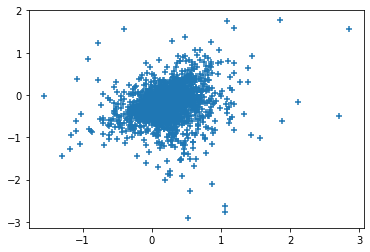

In [ ]:
j=0
www = np.array([w2v.wv[vocab_w[i]][j:j+2] for i in range(len(vocab_w))])
plt.scatter(www.T[0],www.T[1], marker='+')
plt.show()

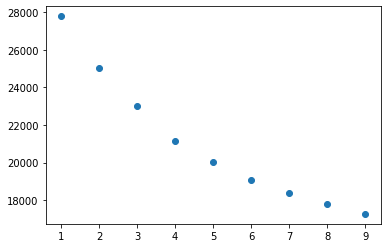

In [ ]:
show_elbow_plot(w2v,vocab_w)

# **загрузка d2v модели**


In [ ]:
d2v = gensim.models.Doc2Vec.load(md+"data/d2v.model")

In [ ]:
def get_d2v_similar_words(pos = "", neg = ""):
    pos = [rs.stem(i) for i in pos.split()]
    neg = [rs.stem(i) for i in neg.split()]
    return d2v.wv.most_similar(positive=pos, negative = neg)

get_d2v_similar_words('путин', '')

In [ ]:
d2v.wv.similarity(['путин','россия'], 'крым')

In [ ]:
d2v.infer_vector(['путин', 'крым'])

In [ ]:
np.linalg.norm(d2v.infer_vector(['путин', 'крым']))

0.058298767

In [ ]:
vocab_d, counts_d, counts_max_d, freq_d = take_from_model(d2v)

In [ ]:
d2v.docvecs.count

770

In [ ]:
import sklearn.cluster as sc
n_clstr = 10

In [ ]:
kmeans = sc.KMeans(init='k-means++',n_clusters=n_clstr , random_state=0,n_jobs = 8).fit(d2v.wv[vocab_d])
cc_X = kmeans.cluster_centers_
len(cc_X)

10

In [ ]:
freq_kmeans = [np.where(kmeans.labels_==i)[0].shape[0] for i in range(len(cc_X))]
freq_kmeans

[234, 1166, 128, 475, 155, 1411, 8, 222, 709, 356]

In [ ]:
mgn = []
cw = []

for i in range(len(cc_X)):

  magn = []
  closest_word_now = []
  for v in vocab_d[kmeans.labels_==i]:
    vec = d2v.wv[v]
    magn_now = np.linalg.norm(vec-cc_X[i])
    closest_word_now+=[v]
    magn+=[magn_now]
    # if magn>magn_now:
    #   closest_word_now = v
    #   magn = magn_now

  mgn+=[magn]
  cw+=[closest_word_now]


In [ ]:
[(np.min(mgn[i]), np.max(mgn[i])) for i in range(len(mgn))]

[(0.031294703, 0.2712331),
 (0.026189005, 0.1727128),
 (0.05998051, 2.0133183),
 (0.029973319, 0.24030335),
 (0.04068097, 1.5790569),
 (0.026477622, 0.4513114),
 (0.9391384, 2.1760485),
 (0.03765154, 1.7204899),
 (0.029066438, 0.1950517),
 (0.03000032, 0.36657444)]

In [ ]:
# cw[0]

In [ ]:
np.max(mgn[6])

2.1760485

In [ ]:
n=6
vec = d2v.wv[cw[n][np.argmax(mgn[n])]]
np.linalg.norm(vec-cc_X[n])

2.1760485

In [ ]:
d2v.wv.vocab['стопкоронавирус.рф'].count

104

In [ ]:
cw[n][np.argmax(mgn[n])]

'стопкоронавирус.рф'

In [ ]:
np.linalg.norm(d2v.wv['стопкоронавирус.рф'])

3.4835043

In [ ]:
d2v.wv['стопкоронавирус.рф']

array([ 0.18057394, -0.17916223, -0.01004103,  0.49509838,  0.14333956,
       -0.38316274, -0.41618267, -0.21068478,  0.3486654 ,  0.00608553,
        0.17113647, -0.04996122, -0.43980935,  0.2509863 ,  0.24437213,
        0.33260888, -0.31708962, -0.58822745,  0.16536056, -0.12480274,
        0.69380635,  0.5489272 ,  0.02213292,  0.7149545 ,  0.13621506,
       -0.26568878,  0.30170318, -0.4472095 , -0.22288883,  0.3691268 ,
       -0.6512158 ,  0.3424208 ,  0.3586781 ,  0.45625928, -0.34566346,
        0.276637  , -0.19769141,  0.5393516 , -0.44732347, -0.04862861,
        0.40810293,  0.10694569,  0.03606271,  0.09981769,  0.19000532,
       -0.0467746 , -0.5542984 , -0.16746256,  0.17216057, -0.34053612,
       -0.5465533 ,  0.14119633,  0.67453426, -0.66048414, -0.17799881,
        0.57164735,  0.35865095, -0.20824328,  0.26705456,  0.30643472,
        0.16787995, -0.6528819 ,  0.45906955, -0.29536512, -0.2333105 ,
       -0.19432516, -0.08314178,  0.04889167, -0.40970752,  0.22

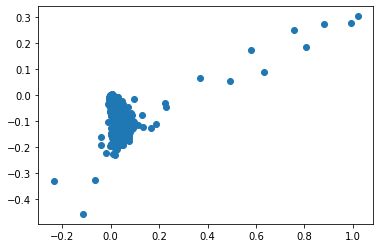

In [ ]:
j=0
ddd = np.array([[d2v.wv[vocab_d[i]][94],d2v.wv[vocab_d[i]][10]] for i in range(len(vocab_d))])
plt.scatter(ddd.T[0],ddd.T[1])
plt.show()

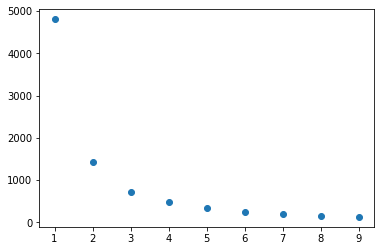

In [ ]:
show_elbow_plot(d2v,vocab_d)

# **загрузка ft**

In [ ]:
ft = gensim.models.FastText.load(md+"data/ft.model")

In [ ]:
ft.wv.most_similar('стопкоронавирус.рф')

[('коронавирусн', 0.934471607208252),
 ('коронавирус', 0.9032109975814819),
 ('вирусн', 0.8954273462295532),
 ('вирусолог', 0.8847116827964783),
 ('бронзов', 0.8701022863388062),
 ('королев', 0.8596134185791016),
 ('киркоров', 0.8508594632148743),
 ('бронз', 0.8467483520507812),
 ('вирус', 0.8437217473983765),
 ('респираторн', 0.8413898944854736)]

In [ ]:
vocab_f, counts_f, counts_max_f, freq_f = take_from_model(ft)

In [ ]:
freq_f

['число',
 'год',
 'росс',
 'котор',
 'российск',
 'такж',
 'нов',
 'стран',
 'сво',
 'слов']

In [ ]:
vocab_f = np.array(list(ft.wv.vocab))

In [ ]:
counts_f = np.array([ft.wv.vocab[v].count for v in vocab_f])

In [ ]:
n=10 # Выводит первые n самых частотных слов
counts_max_f = sorted(np.unique(sorted(counts_f,reverse=True)[:n]),reverse=True)
freq_index = [j  for i in counts_max_f for j in np.where(counts_f == i)[0]]
freq_f = [vocab_f[i] for i in freq_index]
freq_f

['число',
 'год',
 'росс',
 'котор',
 'российск',
 'такж',
 'нов',
 'стран',
 'сво',
 'слов']

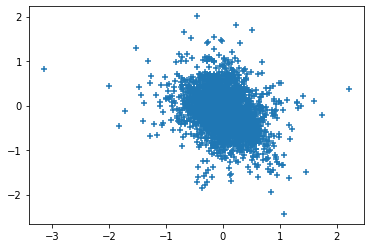

In [ ]:
j=0
fff = np.array([ft.wv[vocab_f[i]][j:j+2] for i in range(len(vocab_f))])
plt.scatter(fff.T[0],fff.T[1], marker='+')
plt.show()

In [ ]:
fff.min()

-1.3520439

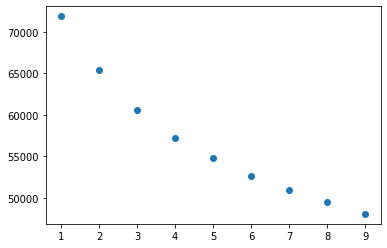

In [ ]:
show_elbow_plot(ft,vocab_f)

# Обработка тегов

In [9]:
tags = [] 
for _ in  data.tags:
    tags+=[_]

tags = np.array(tags)
all_tags = [j for t in tags for j in t]
uniq_tags = np.unique(all_tags) #1183
len(uniq_tags)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


3388

In [10]:
tagsu = dict(zip(uniq_tags, np.zeros(len(uniq_tags)).astype('int64')))
for i in all_tags:
    tagsu[i]+=1
    
utu = np.array([tagsu[i] for i in uniq_tags])# utu - частота тегов uniq_tags
uniq_tags[np.where(utu >300)]

array(['В мире', 'Владимир Путин', 'Коронавирус COVID-19',
       'Коронавирус в России', 'Москва', 'Общество', 'Происшествия',
       'Распространение коронавируса', 'Россия', 'США'], dtype='<U178')

In [11]:
main_tags = set(['В_мире', 'Политика', 'Происшествия', 'Общество', 'Экономика', 'Наука','Вокруг_спорта', 'Культура', 'Туризм'])
main_tags = set(['В мире', 'Политика', 'Происшествия', 'Общество', 'Экономика', 'Наука','Вокруг спорта', 'Культура', 'Туризм'])

In [12]:
m_t_joint = np.where(np.array([not main_tags.isdisjoint(tag) for tag in tags])==True)[0]
m_t_joint.shape

(2906,)

In [31]:
main_tags_list = sorted(list(main_tags))
main_tags_dict = dict(zip(main_tags_list,np.zeros(len(main_tags_list))))
external_counter = 0
for t in tags[m_t_joint]:
  counter=0
  for mtl in main_tags_list:
    if mtl in t:
      main_tags_dict[mtl]+=1
      counter+=1
  if counter>1:
    external_counter+=1
print(external_counter)
main_tags_dict

108


{'В мире': 1112.0,
 'Вокруг спорта': 37.0,
 'Культура': 110.0,
 'Наука': 116.0,
 'Общество': 864.0,
 'Политика': 82.0,
 'Происшествия': 433.0,
 'Туризм': 44.0,
 'Экономика': 216.0}

<BarContainer object of 9 artists>

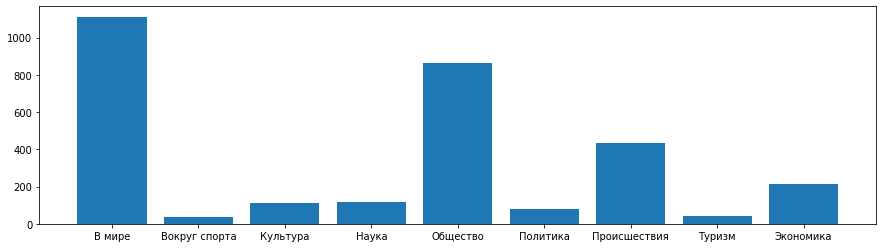

In [40]:
keys = main_tags_dict.keys()
values = main_tags_dict.values()

plt.figure(figsize=(15, 4))
plt.bar(keys, values)

In [15]:
np.sum(list(main_tags_dict.values())), len(tags[m_t_joint])

(3014.0, 2906)

In [45]:
m_t = np.array([main_tags.isdisjoint(tag) for tag in tags])
non_normal_tags = tags[np.where(m_t==True)]
all_non_normal_tags=[]
for nnt in non_normal_tags:
  all_non_normal_tags += nnt
all_non_normal_tags = np.unique(all_non_normal_tags)
len(non_normal_tags)

1089

In [17]:
annt_count = np.array([tagsu[_] for _ in all_non_normal_tags])
all_non_normal_tags[np.where(annt_count >50)]

array(['Авторы', 'Азербайджан', 'Александр Лукашенко',
       'Алексей Навальный', 'Армения', 'Безопасность', 'Белоруссия',
       'Большая пресс-конференция Владимира Путина – 2020',
       'Вакцина "Спутник V"', 'Великобритания', 'Владимир Зеленский',
       'Владимир Путин', 'Германия', 'Госдума РФ', 'Джо Байден',
       'Дмитрий Песков', 'Дональд Трамп', 'Евросоюз', 'Здоровье',
       'Здоровье - Общество', 'Знаменитости', 'Ильхам Алиев', 'Китай',
       'Коронавирус COVID-19', 'Коронавирус в России', 'Коронавирусы',
       'Космос - РИА Наука', 'Молдавия', 'Москва',
       'Московская область (Подмосковье)', 'НАТО', 'Нагорный Карабах',
       'Никол Пашинян', 'Новый год', 'Новый год—2021', 'ООН',
       'Распространение коронавируса', 'Республика Крым', 'Россия', 'США',
       'Санкт-Петербург', 'Северный поток — 2', 'Сергей Лавров',
       'Ситуация в Нагорном Карабахе',
       'Следственный комитет России (СК РФ)', 'Технологии', 'Турция',
       'Украина', 'Федеральная служба бе

# обучение распознаванию тегов

In [18]:
import string
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer 
rs = RussianStemmer()

In [ ]:
import nltk
nltk.download()

In [20]:
stop_words = stopwords.words('russian')
stop_words.extend(['что','однако', 
                   'это', 'так', 'вот', 'быть','уже', 'как', 'в','из-за', '—', '–', 'к', 'на', '...','»', '«','``',"''"])
stop_words.extend(list(string.punctuation))

def tokenize_sent2words_ru(sentence):
    sentence=sentence.lower()
    tokens = word_tokenize(sentence, 'russian')
    tokens = [rs.stem(i) for i in tokens if (i not in stop_words)]
    for i in range(len(tokens)): 
        if tokens[i].isdigit():
            tokens[i] = 'число'
    return tokens


def tokenize_text2words_ru(text):
    res = []
    for sent in sent_tokenize(text, 'russian'):
        res+= tokenize_sent2words_ru(sent)
#     res = [tokenize_sent2words_ru(sent) for sent in sent_tokenize(text, 'russian')]
    return res

In [47]:
# tokenize_text2words_ru(data['main_text'][0])+tags[0]

In [21]:
data_train_for_tags = [tokenize_text2words_ru(main_text)+tags[i] for i, main_text in tqdm(enumerate(data['main_text']))]

In [22]:
w2v_tags = gensim.models.Word2Vec(tqdm(data_train_for_tags), workers=8, iter=20, min_count=1)
w2v_tags.save(md+'data/w2v_tags.model')

In [25]:
w2v_tags.similarity(main_tags_list[0], main_tags_list[0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


1.0

In [54]:
nnt_change=[]
for nnt in non_normal_tags:
  vars = dict(zip(main_tags_list, np.zeros(len(main_tags_list))))
  for t in nnt:
    for mtl in main_tags_list:
      try:
        now_sim = w2v_tags.similarity(t, mtl)
        # vars[mtl]=max(vars[mtl],now_sim)
        vars[mtl]+=now_sim
        # if now_sim==1:
        #   vars[mtl]+=10
      except:
        print(t+' '+ mtl +' не в словаре w2v')
  nnt_change+=[[main_tags_list[np.argmax(list(vars.values()))], nnt ]]
# nnt_change[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  import sys


In [56]:
nnt_change[:10]

[['Экономика',
  ['Иван Вагнер',
   'Международная космическая станция (МКС)',
   'Космос - РИА Наука',
   'Анатолий Иванишин',
   'Дмитрий Рогозин']],
 ['Политика', ['Шоубиз', 'Россия', 'Израиль']],
 ['Политика',
  ['Россия',
   'Наталья Поклонская',
   'Владимир Зеленский',
   'Республика Крым',
   'Украина']],
 ['Вокруг спорта',
  ['Молодежный чемпионат мира по хоккею',
   'Леонид Вайсфельд',
   'Роман Ротенберг',
   'Игорь Ларионов',
   'IIHF',
   'Молодежная сборная России по хоккею с шайбой',
   'Федерация хоккея России',
   'Госдума РФ',
   'Хоккей']],
 ['Политика',
  ['Распространение коронавируса',
   'Коронавирус COVID-19',
   'Алексей Данилов',
   'Максим Степанов',
   'Украина']],
 ['Вокруг спорта', ['ЯсноПонятно', 'Подкаст']],
 ['Туризм',
  ['Распространение коронавируса',
   'Александр Гинцбург',
   'НИИ им. Гамалеи',
   'Коронавирус в России',
   'Коронавирус COVID-19',
   'Россия',
   'Здоровье - Общество']],
 ['Вокруг спорта',
  ['Молодежный чемпионат мира по хоккею',


In [48]:
for i in main_tags_list:
  print('* '+i)# , end='___: '
  print([_ for _ in w2v_tags.most_similar(i)])
  

* В мире
[('Украина', 0.9463106989860535), ('Реджеп Тайип Эрдоган', 0.9460622072219849), ('НАТО', 0.9432941675186157), ('Сергей Лавров', 0.9401751756668091), ('Евросоюз', 0.9377892017364502), ('Турция', 0.9376336336135864), ('Sunday Times', 0.932929515838623), ('Сирия', 0.9284839034080505), ('Иран', 0.928364098072052), ('Франция', 0.9278537034988403)]
* Вокруг спорта
[('Фигурное катание', 0.960860013961792), ('Футбол', 0.9509681463241577), ('Краснодар', 0.9471625089645386), ('Евгений Плющенко', 0.944237232208252), ('Адам Яндиев', 0.9433639049530029), ('Этери Тутберидзе', 0.9427433013916016), ('Ольга Бузова', 0.9426606893539429), ('Единоборства', 0.9418942928314209), ('Смешанные боевые искусства (ММА)', 0.9395397305488586), ('UFC', 0.9355536699295044)]
* Культура
[('Новости культуры', 0.9478762149810791), ('Умер Валентин Гафт', 0.9327935576438904), ('Самоизоляция', 0.9304399490356445), ('Marvel Comics', 0.9279359579086304), ('Музыка', 0.9268271923065186), ('Инстаграм', 0.925955891609191

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


# Графики популярных тегов

In [120]:
grdata = data.groupby(pd.Grouper(key="dt", freq="D")).agg({'views':['sum','min','max','mean']})
grdata

views                               
                 sum    min      max           mean
dt                                                 
2020-12-01   8667329  10112   725859   65661.583333
2020-12-02  10108978  10018   647369   73253.463768
2020-12-03   8976760  10141   681981   66494.518519
2020-12-04   9255032  10142   609116   71744.434109
2020-12-05   9170834  10569   895558   87341.276190
2020-12-06   8445664  10309   811906   83620.435644
2020-12-07   9304533  10047   703171   60813.941176
2020-12-08  11963268  10214   966156   79755.120000
2020-12-09  10219250  10148   911741   68585.570470
2020-12-10   9594070  10051  1038086   70029.708029
2020-12-11   8857178  10028   662897   65608.725926
2020-12-12  11193270  10286   985360   97332.782609
2020-12-13   7342751  10002   540043   76486.989583
2020-12-14   9367984  10075   686330   67395.568345
2020-12-15  14392849  10202  1669187   92857.090323
2020-12-16   9130898  10099   468517   63409.013889
2020-12-17  12524408  10011  1186313   81327.324675
2020-12-18  14466299  10292  1032452   99767.579310
2020-12-19   7791478  10042  1013797   72143.314815
2020-12-20  10818024  10770  1055218  113873.936842
2020-12-21   8716882  10303   930161   61821.858156
2020-12-22   6988018  10170   326336   54593.890625
2020-12-23   9285441  10022   778394   62318.395973
2020-12-24  11872462  10066  1000748   78108.302632
2020-12-25   9077244  10104   734805   60921.100671
2020-12-26   7456191  10086   640314   71011.342857
2020-12-27   7821205  10188  1654026   94231.385542
2020-12-28  10243410  10014   708474   73693.597122
2020-12-29  10242385  10083   672594   80648.700787
2020-12-30   8692574  10007   850414   74935.982759
2020-12-31   9902064  10406  1453139  108813.890110

In [119]:
qwe = np.array(grdata['views']['sum']!=0)

In [103]:
np.array(grdata['views']['sum'].index)[qwe]

array(['2020-01-12T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-03-12T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
       '2020-05-12T00:00:00.000000000', '2020-06-12T00:00:00.000000000',
       '2020-07-12T00:00:00.000000000', '2020-08-12T00:00:00.000000000',
       '2020-09-12T00:00:00.000000000', '2020-10-12T00:00:00.000000000',
       '2020-11-12T00:00:00.000000000', '2020-12-12T00:00:00.000000000',
       '2020-12-13T00:00:00.000000000', '2020-12-14T00:00:00.000000000',
       '2020-12-15T00:00:00.000000000', '2020-12-16T00:00:00.000000000',
       '2020-12-17T00:00:00.000000000', '2020-12-18T00:00:00.000000000',
       '2020-12-19T00:00:00.000000000', '2020-12-20T00:00:00.000000000',
       '2020-12-21T00:00:00.000000000', '2020-12-22T00:00:00.000000000',
       '2020-12-23T00:00:00.000000000', '2020-12-24T00:00:00.000000000',
       '2020-12-25T00:00:00.000000000', '2020-12-26T00:00:00.000000000',
       '2020-12-27T00:00:00.000000000', '2020-12-28

In [69]:
np.array(data['views']==None).sum()

0

In [104]:
data

,views,tags,dt,main_text
0,13334,"[Ситуация в Нагорном Карабахе, Никол Пашинян, ...",2020-12-31 23:55:00,Алиев ответил на обвинения ЮНЕСКО из-за армянс...
1,40433,"[Распространение коронавируса, Панамериканская...",2020-12-31 23:19:00,ВОЗ внесла вакцину Pfizer в список для экстрен...
2,42263,"[Россия, Снегурочка, Дед Мороз, Сургут, ДТП, П...",2020-12-31 21:42:00,В Сургуте Дед Мороз разбился в ДТП. Мужчина в ...
3,29885,"[Домодедово (аэропорт), Шереметьево (аэропорт)...",2020-12-31 21:16:00,В Москве задержали или отменили около 105 рейс...
4,455876,"[Оппозиционная платформа - За жизнь, Ситуация ...",2020-12-31 20:07:00,Депутат Рады надел шапку с красной звездой и о...
...,...,...,...,...
3990,75573,"[Распространение коронавируса, Александр Караб...",2020-01-12 02:12:00,Как легкие восстанавливаются после коронавирус...
3991,160385,"[Костромская область, Марина Удгодская, Россия...",2020-01-12 02:09:00,Названа новая зарплата случайно победившей на ...
3992,188213,"[Россия, Елена Бибикова, Пенсии, Совет Федерац...",2020-01-12 01:27:00,В Совфеде рассказали о выплате россиянам двух ...
3993,725859,"[Россия, Майя Санду, Игорь Додон, Леонид Калаш...",2020-01-12 00:57:00,В Госдуме возмутились отказом Санду признать д...
